In [1]:
#manejo de datos
import pandas as pd
import numpy as np

#gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')   

In [2]:
df = pd.read_csv("../../Datos/" + "carretera_info.csv", encoding='latin1').drop(['road_name','fecha','folio','longitud','latitud'],axis=1)
df.dropna(subset=['lanes'], inplace= True)

# Realiza codificación one-hot en la columna 'road_type'
df_encoded = pd.get_dummies(df, columns=['road_type'], prefix=['road_type'])

# El DataFrame resultante ahora contiene las columnas codificadas one-hot
df_encoded

,temperature_2m,relativehumidity_2m,precipitation,rain,weathercode,windspeed_10m,winddirection_10m,direct_radiation_instant,lanes,maxspeed,road_type_living_street,road_type_primary,road_type_residential,road_type_secondary,road_type_tertiary,road_type_trunk,road_type_trunk_link
1,18.3,74,0.0,0.0,0,2.7,203,0.0,2.0,40.0,False,False,False,False,True,False,False
2,20.9,71,0.0,0.0,0,6.0,155,0.0,2.0,30.0,False,False,False,False,True,False,False
3,17.3,72,0.0,0.0,1,2.3,231,7.0,3.0,40.0,False,True,False,False,False,False,False
4,15.9,85,0.0,0.0,2,6.0,245,0.0,3.0,40.0,False,True,False,False,False,False,False
5,17.3,72,0.0,0.0,1,2.3,231,7.0,3.0,50.0,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167112,11.4,77,0.0,0.0,3,4.4,9,0.0,4.0,40.0,False,True,False,False,False,False,False
167113,19.0,81,0.5,0.5,53,15.4,57,112.0,3.0,50.0,False,True,False,False,False,False,False
167114,18.5,53,0.0,0.0,0,1.1,180,0.0,2.0,40.0,False,False,False,False,True,False,False
167115,13.1,72,0.0,0.0,3,5.9,14,0.0,3.0,40.0,False,True,False,False,False,False,False


## Elegir alguna métrica para determinar número de grupos, usarla y discutirla

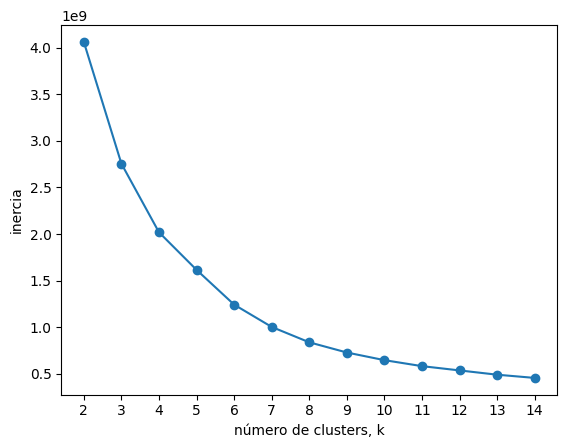

In [3]:
# Importa la librería KMeans desde scikit-learn
from sklearn.cluster import KMeans

# Importa la librería para gráficos
import matplotlib.pyplot as plt

# Define una lista de números de clusters (k) que deseas probar
ks = range(2, 15)

# Inicializa una lista vacía para almacenar las inercias
inertias = []

# Recorre diferentes valores de k y calcula las inercias
for k in ks:
    # Crea una instancia de KMeans con k clusters
    kmeans = KMeans(n_clusters=k)
    
    # Ajusta el modelo KMeans a los datos en df_encoded
    kmeans.fit(df_encoded)
    
    # Agrega la inercia (suma de distancias cuadradas al centro del cluster) a la lista de inertias
    inertias.append(kmeans.inertia_)
    
# Dibuja un gráfico de ks vs inertias para visualizar la curva del codo
plt.plot(ks, inertias, '-o')
plt.xlabel('número de clusters, k')
plt.ylabel('inercia')
plt.xticks(ks)
plt.show()


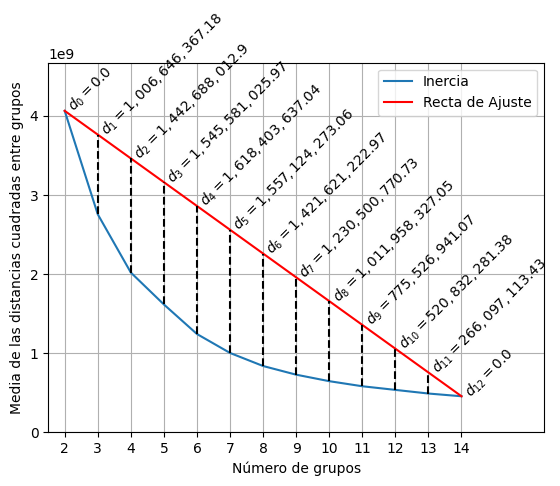

La mayor distancia se obtiene con k = 6.0 por lo que se toma como el mejor número de grupos por el método del codo.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear un DataFrame 'df_inertias' con dos columnas: 'n_clusters' e 'inertia'
df_inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertias})

# Calcular la recta de ajuste mediante mínimos cuadrados
# Usamos los primeros y últimos puntos para la recta
x_coords = df_inertias.iloc[[0, -1], :].n_clusters
y_coords = df_inertias.iloc[[0, -1], :].inertia
A = np.vstack([x_coords, np.ones(len(x_coords))]).T
m, b = np.linalg.lstsq(A, y_coords, rcond=None)[0]

# Calcular las distancias entre cada punto y la recta de ajuste
distancias = np.abs(df_inertias['inertia'] - (m * df_inertias['n_clusters'] + b))

# Encontrar el punto con la mayor distancia
max_distance_point = df_inertias.iloc[distancias.idxmax()]

# Crear una figura y graficar los puntos y la recta de ajuste
plt.figure()
plt.plot(df_inertias.n_clusters, df_inertias.inertia, label='Inercia')
plt.plot(x_coords, y_coords, c='r', label='Recta de Ajuste')

# Etiquetar los puntos y trazar líneas de error
for i, r in df_inertias.iterrows():
    d = f'$d_{{{i}}} = {abs(round(r.inertia - (m * r.n_clusters + b), 2)):,}$'
    plt.annotate(d, xytext=(r.n_clusters, m * r.n_clusters + b), xy=(r.n_clusters, m * r.n_clusters + b), rotation=45)
    plt.plot([r.n_clusters, r.n_clusters], [r.inertia, m * r.n_clusters + b], '--k')

# Configuración de la gráfica
plt.xlabel('Número de grupos')
plt.ylabel('Media de las distancias cuadradas entre grupos')
plt.xlim((1.5, 16.5))
plt.ylim((0, 1.15 * df_inertias.inertia.max()))
plt.xticks(range(2, 15))
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

# Imprimir el mensaje
print("La mayor distancia se obtiene con k =", max_distance_point['n_clusters'], "por lo que se toma como el mejor número de grupos por el método del codo.")


## Aplicar al menos un algoritmo no supervisado a tus datos para encontrar estructuras subyacentes

In [5]:
from sklearn.cluster import KMeans

# Crear una instancia del modelo KMeans con el número de clusters deseado
kmeans = KMeans(n_clusters=6)  
kmeans.fit(df_encoded)  # Ajustar el modelo KMeans a los datos
labels = kmeans.labels_  # Obtener las etiquetas de los clusters asignadas a cada punto de datos


In [6]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir los datos a 2 dimensiones
pca = PCA(n_components=2)  # Crear una instancia de PCA con 2 componentes principales
data_2d = pca.fit_transform(df_encoded)  # Realizar la reducción de dimensionalidad a 2D


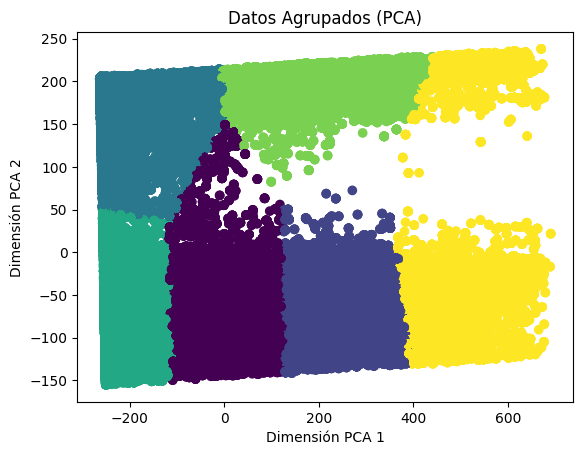

In [7]:
import matplotlib.pyplot as plt

# Crear un gráfico de dispersión con asignación de colores por cluster
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
plt.title('Datos Agrupados (PCA)') 
plt.xlabel('Dimensión PCA 1')  
plt.ylabel('Dimensión PCA 2')  
plt.show() 


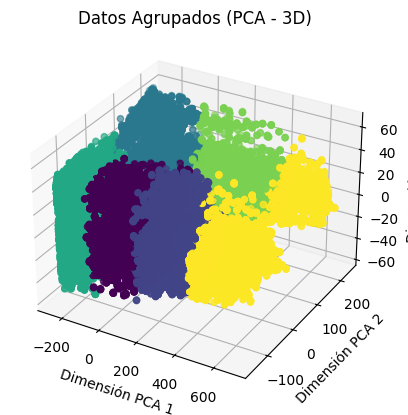

In [8]:
from mpl_toolkits.mplot3d import Axes3D  # Importar herramientas de gráficos 3D

# Aplicar PCA para reducir los datos a 3D
pca = PCA(n_components=3)
data_3d = pca.fit_transform(df_encoded)

# Crear un gráfico de dispersión en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_3d[:, 0], data_3d[:, 1], data_3d[:, 2], c=labels, cmap='viridis')
ax.set_title('Datos Agrupados (PCA - 3D)')  
ax.set_xlabel('Dimensión PCA 1') 
ax.set_ylabel('Dimensión PCA 2')  
ax.set_zlabel('Dimensión PCA 3')  
plt.show()  
